<div style="text-align: right"><b>Daniel Stevens</b><br><i>Analise Hofman<i/><br><i>Introduction to Data Visualization- Oct21Dec21</i><br><i>3 Jan 2022</i></div>

# **Vancouver Street Trees- Exploratory Data Analysis**

### Questions to answer:
* How do the various genera in the Vancouver street tree population rank in relation to one another in terms of importance to the total population?
* How does the range in tree diameter contribute to the relative importance of each genera and is there a difference between them?
* How do Vancouver neighbourhoods compare in terms of importance value density of the street tree population?
* How is the relative importance of each genus distributed throughout Vancouver?

In [ ]:
import pandas as pd
import altair as alt
import numpy as np
alt.data_transformers.enable('default', max_rows=1000000)

### Data Wrangling

First, let's read in the data from the `vancouver_trees` dataset and familiarize ourselves with its attributes.

In [ ]:
trees_url = 'https://raw.githubusercontent.com/UBC-MDS/exploratory-data-viz/main/data/vancouver_trees.csv'
trees_df = pd.read_csv(trees_url)
trees_df.head(2)

In [ ]:
trees_df.info()

In [ ]:
trees_df.loc[:,'tree_id'].nunique()

The `trees_df` dataframe consists of 30,000 rows, each representing a unique Vancouver street tree, and 21 columns of various dtypes including float, integer and object, each representing a different tree variable. Variable data types range from categorical (e.g. `genus_name`), quantitative (e.g. `diameter`), ordinal (e.g. `height_range_id`), temporal (e.g. `date_planted`) and spatial (e.g. `latitude`, `longitude`). There are missing values in the `date_planted`, `plant_area` and `cultivar_name` columns.

In [ ]:
trees_df.describe()

The mean diameter of the observed trees is 12.20 inches, while the median diameter is 10.00 inches, indicating that the distribution of tree diameter for the full dataset is right-skewed. The maximum diameter is 317.00 inches (over 26 ft), while the minimum diameter is 0.00 inches. These maximum and minimum values both appear unreasonable and will require further investigation to determine their validity. Let's create a rug plot to quickly visualize the distribution of tree diameter.

In [ ]:
trees_rugplot= alt.Chart(trees_df, title='Fig. 1').mark_tick(clip=True).encode(
    x=alt.X('diameter')
).properties(width=800)

trees_rugplot

The rugplot above looks fairly saturated until approximately 60 inches. Let's filter the dataframe and inspect rows with diameter values exceeding 60 inches, as well as rows with diameter values equaling 0.

In [ ]:
tree_outliers = trees_df[
    (trees_df["diameter"] > 60) | (trees_df["diameter"] == 0)
].sort_values("diameter")
tree_outliers.head(2)

We can use the latitude and longitude of the outliers listed in the `tree_outliers` dataframe to locate and visualize each tree on Google Maps using its streetview capability. Each outlier tree can be assessed to see if the diameter listed in the data set is reasonable given the appearance of the tree. 

Let's start off with tree ID 43236, listed as a <i>Pissard Plum</i> in the Oakridge neighbourhood with a diameter of 0 inches:

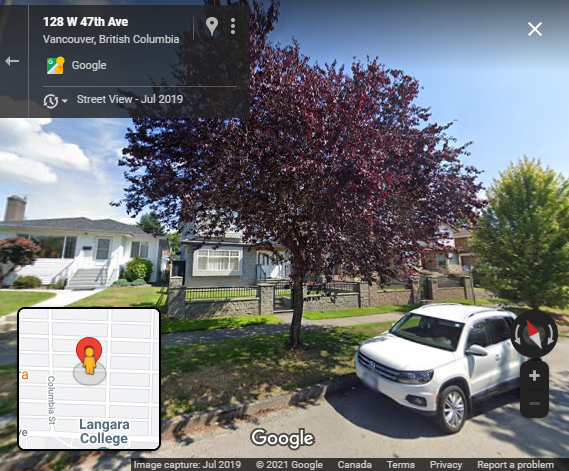

From the image above, it is evident that this tree is not close to 0 inches in diameter.

Next let's look at tree ID 149285 which lies at the other end of the diameter outlier spectrum. This tree is the largest tree listed in the dataset, categorized as a <i>Maple Species</i> in the Kitsilano neighbourhood with a diameter of 317 inches (over 26 feet):

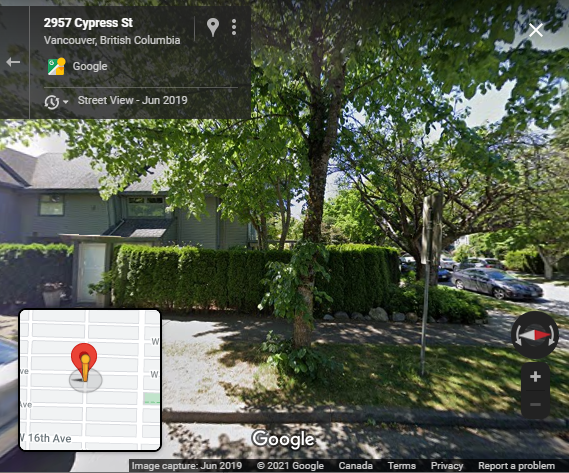

It is obvious from this visualization that the tree does not have a diameter of more than 26 feet.

The diameters of tree IDs 43236 and 149285 are evidently inaccurate, and thus can bet removed from the dataset.

Upon examination of the remaining trees in the `tree_outliers` dataframe through Google Maps streetview, we can see that a majority of the diameter measurements are inaccurate, however, the validity of some diameters are more ambiguous. As an example, let's look at tree ID 93845, listed as a <i>Deodar Cedar</i> in the Kitsilano neighbourhood with a diameter of 71 inches:

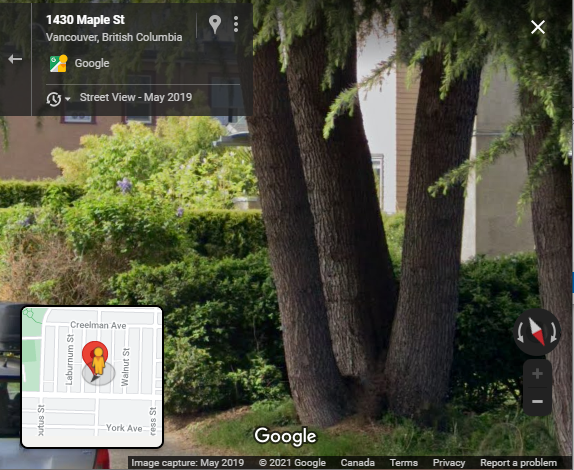

This is a multi-stemmed tree with an overall diameter of 71 inches, the three individual stems each having a smaller diameter. In a study examining methods of multi-stemmed tree measurement, Magarik et al found that there was no significant difference in the predictive power of overall diameter in regards to tree height and crown width of multi-stemmed trees (Magarik et al 2020). For this reason, we can feel justified in keeping these trees as part of the dataset.

Of the outliers listed in the `tree_outlier` dataframe, tree IDs 87265, 168648, 142102, 142079 and 126267 can be kept as part of the data set as their listed diameters are reasonable based on visualization through Google Maps. The remaining outlier trees can be removed from the analysis.

Although this method is not the most robust as far as outlier detection and removal, it is adequate for the scope of this analysis. Let's remove the outliers as listed above.

In [ ]:
outlier_tree_ids = tree_outliers[~tree_outliers['tree_id'].isin([87265,168648,142102,142079,126267])].loc[:,'tree_id'].tolist()
trees_trimmed = trees_df[~trees_df['tree_id'].isin(outlier_tree_ids)]
trees_df.shape[0]-trees_trimmed.shape[0]

In [ ]:
tree_outliers['tree_id'].tolist()

In total, 14 obervations were removed from a dataset consisting of 30,000 rows. This is less than 0.05% of the total dataset.

In [ ]:
trees_trimmed.describe()

The maximum diameter of the trimmed data set is 72 inches while the minimum is now 0.25. These values are more reasonable. The mean diameter decreased by only 0.03 inches, from 12.20 inches to 12.17 inches. Removal of the outlier trees decreased the diameter range to a reasonable value while having little effect on the overall count of observations and mean of the diameter. 

Let's plot a histogram to see the overall distribution of diameters of our trimmed data set. We have chosen to bin the trees in 2 inch intervals as this is the standard way of classifying trees into size categories according to the US Department of Agriculture's Forest Service <i>Forest Inventory and Analysis</i> glossary (“USDA Forest Service”).

In [ ]:
trees_histogram = alt.Chart(trees_trimmed, title='Fig. 2').mark_bar().encode(
    x=alt.X('diameter', bin=alt.Bin(step=2)),
    y='count()',
    tooltip='count()')
trees_histogram

It appears that the most common tree diameter in the Vancouver street tree population is between 2 and 4 inches, and the frequency of diameter generally decreases as tree diameter increases. The diameter distribution remains right-skewed.

Now that we have familiarized ourselves with the data and removed some evident outliers, let's begin our exploratory analysis.

### How do the various genera in the Vancouver street tree population rank in relation to one another in terms of importance in the total population?

A relative importance value represents the dominance of a specific species or genus in the population compared to all other species or genera. Importance values are traditionally utilized in forest ecology, however a modified version of this calculation can be used to assess the relative importance of street trees (McPherson and Rowntree, 1989).

Let's use the following formulas, applied by McPherson and Rowntree (1989) to assess the relative importance of street tree species within a population, to assess the relative importance of Vancouver street tress at the genus level within the Vancouver stree tree population: 

* $ importance\ value\ =\ relative\ abundance + relative\ dominance $
<br>
<br>
* $ relative\ abundance\ =\ \frac{number\ of\ individuals\ of\ genus\ X}{total\ individuals\ in\ population}\cdot100\\ $
<br>
* $ basal\ area\ =\pi\cdot(\frac{diameter}{2})^2\\ $
* $ relative\ dominance\ =\ \frac{total\ basal\ area\ of\ genus\ X}{total\ basal\ area\ of\ population}\cdot100\\ $
<br>
* $ relative\ importance\ =\ \frac{total\ importance\ value\ of\ genus\ X}{total\ importance\ value\ of\ population}\cdot100\\ $

Upon inspection of the formulas above, the relative importance calculation takes both overall number and overall basal area of each tree genus into equal account and assigns a percentage of total importance to each genus based on these parameters.

We will use the `tree_id` column to provide a count of individuals, the `genus_name` column for grouping, and the `diameter` column to calculate the basal area. We will also keep the `neighbourhood name` column to be utilized later in the analysis.

We will also convert the diameter and basal area units to m and m<sup>2</sup> respectively, and calculate the mean basal area for each genus.

In [ ]:
# Find basal area of each tree and convert to m**2, convert diameter to m
genus_importance = (
    trees_trimmed.loc[:, ["tree_id", "neighbourhood_name", "genus_name", "diameter","latitude","longitude"]]
    .assign(
        basal_area_m2=(np.pi * (trees_df["diameter"] / 2) ** 2) * 0.00064516,
        diameter=trees_df["diameter"] * 0.0254,
    )
    .rename(columns={"diameter": "diameter_m"})
)

# Find relative abundance and relative dominance for each tree
genus_importance = genus_importance.assign(
    relative_abundance=1 / genus_importance["tree_id"].count(),
    relative_dominance=genus_importance["basal_area_m2"]
    / genus_importance["basal_area_m2"].sum(),
)

# Find importance value for each tree
genus_importance = genus_importance.assign(
    importance_value=genus_importance["relative_abundance"]
    + genus_importance["relative_dominance"]
)

# Find relative importance value for each tree
genus_importance = genus_importance.assign(
    relative_importance=genus_importance["importance_value"]
    / genus_importance["importance_value"].sum()
)

genus_importance.head(2)

Let's group by `genus_name` to find aggregate values of the columns of interest and calculate the relative importance value for each genera.

In [ ]:
# Aggregate values by genus
genus_importance_grouped = (
    genus_importance.groupby(by="genus_name")
    .agg(
        {
            "tree_id": "count",
            "basal_area_m2": ["mean", "sum"],
            "relative_abundance": "sum",
            "relative_dominance": "sum",
            "importance_value": "sum",
            "relative_importance": "sum"
        }
    )
    .reset_index()
    .rename(columns={"tree_id": "species_count"})
)
# Flatten multi-indexed columns
genus_importance_grouped.columns = genus_importance_grouped.columns.to_flat_index()

# Rename flattened columns
genus_importance_grouped.columns = [
    "genus_name",
    "genus_count",
    "mean_basal_area",
    "total_basal_area",
    "relative_abundance",
    "relative_dominance",
    "importance_value",
    "relative_importance"
]

# Calculate relative importance value (%)
genus_importance_grouped = genus_importance_grouped.assign(
    relative_importance = genus_importance_grouped['importance_value']
    /genus_importance_grouped['importance_value'].sum() 
)
# Sort observations in descending order of importance values
genus_importance_grouped = genus_importance_grouped.sort_values(
    by="importance_value", ascending=False
).assign(importance_rank = genus_importance_grouped.loc[:,"relative_importance"].rank(ascending=False))
genus_importance_grouped.head(2)

In [ ]:
genus_importance_grouped.loc[:,'genus_name'].nunique()

Now that we have calculated our desired values for all 82 genera in the Vancouver street tree population, let's create a repeat plot to examine their relationships and look for any distinctive groups.

In [ ]:
numeric_cols = genus_importance_grouped.select_dtypes(include='number').columns.tolist()

In [ ]:
genus_importance_repeat = (
    alt.Chart(genus_importance_grouped)
    .mark_circle()
    .encode(
        x=alt.X(alt.repeat("column"), type="quantitative", scale=alt.Scale(zero=False)),
        y=alt.Y(alt.repeat("row"), type="quantitative", scale=alt.Scale(zero=False)),
        tooltip=[
            "genus_name",
            "relative_abundance",
            "relative_dominance",
            "importance_value",
        ],
    )
    .properties(width=150, height=150)
    .repeat(column=numeric_cols, row=numeric_cols)
)
genus_importance_repeat.properties(title='Fig. 3')

Looking at the repeat plots above, there are 2 consistent outlying genera, <i>Prunus</i> and <i>Acer</i>. 

The `mean_basal_area` vs `genus_count` plot shows that <i>Prunus</i> and <i>Acer</i> are on the lower end of mean basal area range for the population, but are outliers when it comes to total count in the population.

The `relative_dominance` vs. `relative_abundance` plot shows that <i>Prunus</i> and <i>Acer</i> are outliers in both relative abundance and relative dominance. In conjunction with the `mean_basal_area` vs `genus_count` plot, we can conclude that this is a result of their high numbers in the population. The higher mean basal area of other genera, such as <i>Quercus</i> is not enough to compensate for their low numbers in the population to allow these genera to compete with <i>Prunus</i> and <i>Acer</i> in terms of importance. This is supported by the `relative_abundance` vs `importance_rank` plot which shows a general trend in the Vancouver tree population of decreasing importance as relative abundance decreases.

As there are over 80 unique genera in the Vancouver street tree population, let's visualize the importance values for only the top ten most important genera in a bar graph.

In [ ]:
top_10_genus = genus_importance_grouped.nlargest(10,'relative_importance').loc[:,'genus_name'].tolist()

genera_importance_bar = (
    alt.Chart(genus_importance_grouped[genus_importance_grouped['genus_name'].isin(top_10_genus)])
    .mark_bar()
    .encode(
        x=alt.X("relative_importance"),
        y=alt.Y("genus_name", sort="x"),
        tooltip="relative_importance",
    )
)
genera_importance_bar.properties(title='Fig. 4')


The bar graph above gives a strong visualization of the relative size of the relative importance values for the top 10 genera, and clearly demonstrates that there are 2 genera, <i>Prunus</i> and <i>Acer</i>, that highly dominant over all other genera in terms of importance but are nearly equal to each other. We can combine the bar graph with the `relative_dominance` vs `relative_abundance` scatter plot to demonstrate how abundance and dominance for each genus contributes to its importance in the tree population. We can filter the scatter plot to only include the top 10 genera, to correspond to the bar graph, and add labels to point out the outlier <i>Prunus</i> and <i>Acer</i>  genera. The bar graph can be simplified by removing the x axis and adding labels to each bar with rounded relative_importance values. We can add selections to both the bar graph and scatter plot to highlight corresponding bars and points when selected, and show genus names in the scatter plot only when selected to keep it cleaner looking. We can initialize the selection on the top 3 genera.

### What is the distribution of relative importance within the size ranges of the genera comprising the Vancouver street tree population?

Since we discovered there are over 80 different genera in the Vancouver street tree population, let's limit our exploratory visualization to the top 10 most important genera.

We can use data calculated in the genus_importance table in a bar graph and bin the diameters at every 5cm (as this is the standard way of classifying trees into size categories according to the US Department of Agriculture's Forest Service <i>Forest Inventory and Analysis</i> glossary (“USDA Forest Service”)) to see how each size class contributes to each genus's importance. We can facet by genus, normalize to the genus' relative importance and compare the distributions to see if there is any noticeable difference.

In [ ]:
size_importance = (
    alt.Chart(genus_importance[genus_importance["genus_name"].isin(top_10_genus)])
    .transform_joinaggregate(
        total_importance="sum(relative_importance)", groupby=["genus_name"]
    )
    .transform_calculate(
        percent_of_importance="datum.relative_importance / datum.total_importance"
    )
    .mark_bar()
    .encode(
        x=alt.X("diameter_m:Q", bin=alt.Bin(step=0.05)),
        y=alt.Y("sum(percent_of_importance):Q"),
        color="genus_name:N",
        tooltip="sum(percent_of_importance):Q",
    )
    .properties(height=250, width=250)
    .facet("genus_name", columns=3)
)
size_importance.properties(title='Fig. 5')

Looking at the array of graphs, we can see that the distribution of importance value among size classes is very different between genera. When <i>Prunus</i> and <i>Acer</i>  are compared, it can be seen that smaller trees contribute more to Acer's relative importance while more of <i>Prunus'</i> relative importance is held in trees of larger diameter.The importance distribution of <i>Quercus</i> is much flatter compared to that of <i>Acer</i> and <i>Prunus</i>, and less skewed.

Since <i>Prunus</i> and <i>Acer</i> are of similar relative importance values, we can compare these 2 distributions to show how genera with different levels of abundance can have a similar level of importance in a tree population due to a differing distribution of tree sizes. We can include <i>Quercus</i> to include a greater variety of distributions. We can also add a corresponding line graph showing how importance value accumlates over the size classes of each genus. <i>Acer</i> will show the steepest initial slope as more of its importance value is concentrated in the lower size classes, followed by <i>Prunus</i>, and <i>Quercus</i> will show a less steep slope as importance value is more evenly distributed among its size classes. We can use color to distinguish between the three genera. We can add a selection function to the importance distribution charts so the user can scrub through the various size classes and see the corresponding cumulative importance value in the line graph. 

### What neighbourhoods are most important in terms of importance value density of all its genera?

First we will import land area data for each neighbourhood obtained from community statistics census data available through the [City of Vancouver Website](http://vancouver.ca/news-calendar/areas-of-the-city.aspx) (based on the 2016 short form census) and uploaded to a [GitHub Data Repository](https://raw.githubusercontent.com/Daniel-J-Stevens/ubc-kcds_data-visualization_capstone-project/main/data/neighbourhood_demographics.csv). This is given in hectares, so we will convert the values to Km<sup>2</sup>.

In [ ]:
url_neighbourhood_demographics = "https://raw.githubusercontent.com/Daniel-J-Stevens/ubc-kcds_data-visualization_capstone-project/main/data/neighbourhood_demographics.csv"

neighbourhood_land_area = pd.read_csv(
    url_neighbourhood_demographics, usecols=["neighbourhood_name", "land_area"]
)
neighbourhood_land_area = neighbourhood_land_area.assign(
    land_area_km2=neighbourhood_land_area["land_area"] / 100
)
neighbourhood_land_area.head(2)

We want to visualize the importance value density of each neighbourhood on a map. First, we will calculate the the total importance value of each neighbourhood in a new dataframe, merge this with the land area data, and calculate the importance value density for each neighbourhood.

In [ ]:
neighbourhood_importance = (
    genus_importance.groupby(by="neighbourhood_name")
    .agg({"importance_value": "sum", "latitude": "median", "longitude": "median"})
    .reset_index()
    .sort_values(by="importance_value", ascending=False)
)
neighbourhood_importance = neighbourhood_importance.merge(
    neighbourhood_land_area.loc[:, ["neighbourhood_name", "land_area_km2"]],
    on="neighbourhood_name",
    how="left",
)
neighbourhood_importance = neighbourhood_importance.assign(
    importance_value_density=(
        neighbourhood_importance["importance_value"]
        / neighbourhood_importance["land_area_km2"]
    )
    * 100
)
neighbourhood_importance.head(2)

Next, we will import the geojson data for Vancouver neighbourhoods. Code is taken from the [Final Project Map Help document](https://mark-prod-mds.stat.ubc.ca/jupyter/user/768695/doc/tree/data-viz-students/release/final_project/final_project_extras.ipynb).

In [ ]:
url_geojson = "https://raw.githubusercontent.com/UBC-MDS/exploratory-data-viz/main/data/local-area-boundary.geojson"
data_geojson_remote = alt.Data(
    url=url_geojson, format=alt.DataFormat(property="features", type="json")
)

Finally, we will plot a geoshape chart, using the 'id' field from the geojson file to lookup the `importance_value_density` from the `neighbourhood_importance` dataframe and add it to the color channel of the chart.

In [ ]:
neighbourhood_importance_map = (
    alt.Chart(data_geojson_remote)
    .mark_geoshape(stroke="black")
    .transform_lookup(
        lookup="properties.name",
        from_=alt.LookupData(
            neighbourhood_importance,
            "neighbourhood_name",
            ["neighbourhood_name", "importance_value_density"],
        ),
    )
    .encode(
        color=alt.Color(
            "importance_value_density:Q", scale=alt.Scale(scheme="yellowgreen")
        ),
        tooltip=["neighbourhood_name:N", "importance_value_density:Q"],
    )
    .project(type="identity", reflectY=True)
    .properties(height=300)
)
neighbourhood_importance_map.properties(title='Fig. 6')

Kitsilano highest importance value density at 2.5 / Km<sup>2</sup>, followed closely by adjacent neighbourhoods of Shaugnessy and West End, each at approximately 2.4 / Km<sup>2</sup>. Strathcona shows the lowest importance value density at 0.71 / Km<sup>2</sup>.

The map gives a good overall sense of importance value density of all genera in each neighbourhood, however, it is difficult to distinguish between colour values of neighbourhoods whose values are close together. Let's plot the text of the importance value density for each neighbourhood on top of each neighbourhood.

In [ ]:
neighbourhood_importance_text = (
    alt.Chart(neighbourhood_importance)
    .mark_text()
    .encode(
        latitude="latitude",
        longitude="longitude",
        text=alt.Text("importance_value_density", format=".2"),
    )
)
(neighbourhood_importance_map + neighbourhood_importance_text).properties(title='Fig. 7')

The colour scale allows the areas with the highest and lowest importance value densities to be easily identified, while the text allows for more granular comparison between neighbourhoods with similar values.

We can also add an accompanying chart to the right of the map with text only that will display the neighbourhood names in order of importance. If the user hovers over a neighbourhood area on the map or a neighbourhood name on the text chart, the corresponding text or neighbourhood area will be highlighted in red. This will allow for easy identification of neighbourhood names and areas.

### How is the relative importance of each genera distributed throughout Vancouver?

We will limit this visualization to the top 10 genera in terms of importance. We can use a heatmap to communicate the relative importance each genus contributes to the overall population within each neighbourhood, and we can compare the importance of a single genus between neighbourhoods.

To make this visualization more powerful, we can sort the genus_name in order of descending relative importance, and the neighbourhood name in ascending relative importance using the color channel

In [ ]:
neighbourhood_genus_importance = alt.Chart(genus_importance[genus_importance['genus_name'].isin(top_10_genus)]).mark_rect().encode(
    x=alt.X('genus_name', sort='-color'),
    y=alt.Y('neighbourhood_name', sort='color'),
    color=alt.Color('sum(relative_importance)'),
    tooltip=['sum(relative_importance)']
)
neighbourhood_genus_importance.properties(title='Fig. 8')

<i>Acer</i> appears to have the highest relative importance in Dunbar-Southlands, while <i>Prunus</i> appears to have the highest relative importance in Victoria-Fraserview.

The top 10 genus appear to be in all neighbourhoods, except for <i>Ulmus</i> which is not present in Sunset and Hastings-Sunrise and <i>Aesculus</i> which is not present in Killarney.

We can use this heat map as a selection tool to allow the user to explore and compare the distribution of trees throughout the city. When a user selects a rectangle in the heat map, the corresponding neighbourhood map will be displayed and the tree locations plotted. The tree points will be hyperlinked to Google maps to allow the user to view the tree through streetview. An overview map will display where the neighbourhood is located in the city. We can add a dropdown selector to allow the user to subset the heat map to a single genus, and a slider linked to the genus importance ranking to allow the user to subset a certain number of genera in importance rank order instead of restricting the heat map to only the top 10 genera.

Let's validate the neighbourhood data to ensure its accuracy by creating a point map using the latitude and longitude of each tree and faceting by neighbourhood. Any points lying outside of the neighbourhood boundary will be removed from the analysis as the data within the observation is not internally consistent.

In [ ]:
base_map = alt.Chart(data_geojson_remote).mark_geoshape(fill=None, stroke='black').encode(
).project(type='identity', reflectY=True)
neighbourhood_trees = alt.Chart().mark_circle(size=10).encode(
    latitude='latitude:Q',
    longitude='longitude:Q',
    tooltip=[alt.Tooltip('tree_id:N')]
)
alt.layer(base_map, neighbourhood_trees, data=trees_df).properties(width=450).facet('neighbourhood_name:N', columns=2).properties(title='Fig. 9')

Upon inspection of the facet chart above, the following tree IDs should be removed from the dataset as, based on their latitude and longitude, they fall outside of their specified neighbourhood:

In [ ]:
neighbourhood_outliers=[
    255981,264928,256165, 255911, # Arbutus Ridge
    270750, 59956, # Downtown
    256819, 256822, 256701, 256717, 256719, 256890, 256653, 256706, 256803, 201285, # Dunbar-Southlands
    227312, # Grandview-Woodland
    256183, 255969, 256270, # Kitsilano
    141289, # Mount Pleasant
    256896, 267123, # Renfrew-Collingwood
    263937, # South Cambie
    255068, # West End
    257203, 256894, 257095, 257093 # West Point Grey    
]

## Conclusion

In order to create clean visualizations, it is important that we filter the dataset to eliminate data points that, although they may not drastically change the overall conclusions drawn, may be distracting or confuse the audience. We will filter out the diameter outliers that we determined to be invalid, as well as the neighbourhood outliers.

<b>How do the various genera in the Vancouver street tree population rank in relation to one another in terms of importance in the total population?</b>
* We will include a bar chart, showing the relative importance value by genus (Fig. 4)
* We will include a scatter plot of relative dominance vs relative abundance, encoding relative importance value to size (Fig. 3, relative dominance vs relative abundance facet)
* We will add a reference line to the scatter plot which will represent the mean basal area of the population.
* We will include only the top 10 genera in this visualization

<b> How do the different size classes of the top 3 genera contribute to each genus' importance in the population, and is there a difference in this distribution between the genera?</b>
* We will include a bar chart, binning tree diameters in 5cm size classes, faceting by genus, showing how each size class contributes to each genus' total importance. Each chart will be normalized to the genus' total importance to allow for easy comparison between genera (Fig. 5)
* We will include a second plot, showing the cumulative importance value of each genera over its size classes.
* We will simplify the visualization by restrictiong to the top 3 genera in terms of importance value, as these are the most prevalent genera in the street tree population.

<b>How do Vancouver neighbourhoods compare in terms of importance value density of the street tree population?</b>
* We will include a chloropleth map with importance value density encoded to the color channel. (Fig. 6)
* We will add a text overlay to the chlorpleth map of the importance value density values to allow for greater distinction between neighbourhoods (Fig. 7)
* We will add a text chart to the right of the chloropleth map, listing neighbourhoods in the order of importance value density rank. These will be linked with the neighbourhood map, and each will be highlighted upon hovering to allow for easy identificaiton of neighbourhood and area.

<b>How is the relative importance of each genera distributed throughout Vancouver? (DASHBOARD)</b>
* We will include a heat map of genus vs. neighbourhood, with relative importance encoded to the color channel (Fig. 8)
* We will use the heat map as a multi-selection tool, allowing the visualization of the tree distribution of the selected genus in the selected neighbourhood (Fig. 9)
* We will include an overview map to indicate the position of the selected neighbourhood within the city of Vancouver.
* Will provide a dropdown to allow the user to subset the heatmap to a single genus.
* We will include a slider that will allow the user to subset the heatmap by ascending genus ranking.

For the final analysis report, we will use the Altair server, and process data within the Altair module.

## References

### Articles & Reports
City of Vancouver and Vancouver Park Board. 2018. Urban Forest Strategy:2018 Update. Vancouver, Canada. Retreived from: https://vancouver.ca/files/cov/urban-forest-strategy.pdf

Gomez, Michelle. “June Heat Wave Was the Deadliest Weather Event in Canadian History, Experts Say” [Vancouver, BC]. CBC News, 2 Oct. 2021, www.cbc.ca/news/canada/british-columbia/ubcm-heat-dome-panel-1.6189061.

Magarik, Yasha A. S., et al. “How Should We Measure the DBH of Multi-Stemmed Urban Trees?” Urban Forestry & Urban Greening, vol. 47, 2020, p. 126481. Crossref, https://doi.org/10.1016/j.ufug.2019.126481.

McPherson, E. Gregory, and Rowan A. Rowntree. “Using Structural Measures to Compare: Twenty-Two U.S. Street Tree Populations.” Landscape Journal, vol. 8, no. 1, 1989, pp. 13–23. JSTOR, www.jstor.org/stable/43323997.

Metro Vancouver. 2016. Climate Projections for Metro Vancouver. Burnaby, Canada. Retrieved from: http://www.metrovancouver.org/services/air-quality/AirQualityPublications/ClimateProjectionsForMetroVancouver.pdf

“USDA Forest Service.” USDA Northern Research Station, www.nrs.fs.fed.us/fia/data-tools/state-reports/glossary. Accessed 20 Dec. 2021.

### Data Sources

<b>Subsetted Street trees dataset</b>
<br>
https://raw.githubusercontent.com/UBC-MDS/exploratory-data-viz/main/data/vancouver_trees.csv
    
<b>Full Street trees dataset</b>
<br>
Vancouver Board of Parks and Recreation. City of Vancouver Open Data Portal. Street Trees. City of Vancouver. 2016. https://opendata.vancouver.ca/explore/dataset/street-trees/information/?disjunctive.species_name&disjunctive.common_name&disjunctive.height_range_id

<b>Neighbourhood land area</b>
<br>
Vancouver, City Of. “Areas of the City.” City of Vancouver, https://vancouver.ca/news-calendar/areas-of-the-city.aspx. Accessed 20 Dec. 2021.

<b>Vancouver GeoJSON</b>
<br>
https://raw.githubusercontent.com/UBC-MDS/exploratory-data-viz/main/data/local-area-boundary.geojson

### Help Documents

“Aggregate Transforms — Altair 4.2.0 Documentation.” Altair: Declarative Visualization in Python. User Guide., https://altair-viz.github.io/user_guide/transform/aggregate.html. Accessed 4 Jan. 2022.

“Calculate Transform — Altair 4.2.0 Documentation.” Altair: Declarative Visualization in Python. User Guide., https://altair-viz.github.io/user_guide/transform/calculate.html?highlight=transform%20calculate.

“Filter Transform — Altair 4.2.0 Documentation.” Altair: Declarative Visualization in Python. User Guide., https://altair-viz.github.io/user_guide/transform/filter.html.

“Join Aggregate Transform — Altair 4.2.0 Documentation.” Altair: Declarative Visualization in Python. User Guide., https://altair-viz.github.io/user_guide/transform/joinaggregate.html.

"Map Help for Final Project." Introduction to Data Visualization. https://mark-prod-mds.stat.ubc.ca/jupyter/user/768695/doc/tree/data-viz-students/release/final_project/final_project_extras.ipynb